# Embedding Models Exploration for Qdrant / Exploración de Modelos de Embedding para Qdrant

**Goal**: Explore different embedding models to determine which one is most suitable for our RAG system for queries about Paraguayan labor law.

**Approach**:
- Compare performance of different embedding models
- Evaluate loading and search speed
- Analyze quality of results for legal queries
- Provide recommendations based on metrics

**Models to Evaluate**:
1. [**sentence-transformers/all-MiniLM-L6-v2**](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) - Light and fast model 
2. [**sentence-transformers/all-mpnet-base-v2**](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - Balanced model
3. [**sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - Multilingual model
4. [**sentence-transformers/all-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) - Alternative lightweight
5. [**hiiamsid/sentence_similarity_spanish_es**](https://huggingface.co/hiiamsid/sentence_similarity_spanish_es?utm_source=chatgpt.com) - Spanish model
6. [**jinaai/jina-embeddings-v2-base-es**](https://huggingface.co/jinaai/jina-embeddings-v2-base-es?utm_source=chatgpt.com) - Spanish model

---

**Objetivo**: Explorar diferentes modelos de embedding para determinar cuál es el más adecuado para nuestro sistema RAG de consultas sobre la ley laboral paraguaya.

**Enfoque**:
- Comparar rendimiento de diferentes modelos de embedding
- Evaluar velocidad de carga y búsqueda
- Analizar calidad de resultados para consultas legales
- Proporcionar recomendaciones basadas en métricas

**Modelos a Evaluar**:
1. [**sentence-transformers/all-MiniLM-L6-v2**](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) - Modelo ligero y rápido
2. [**sentence-transformers/all-mpnet-base-v2**](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - Modelo balanceado
3. [**sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - Modelo multilingüe
4. [**sentence-transformers/all-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) - Alternativo ligero
5. [**hiiamsid/sentence_similarity_spanish_es**](https://huggingface.co/hiiamsid/sentence_similarity_spanish_es?utm_source=chatgpt.com) - Modelo en Español
6. [**jinaai/jina-embeddings-v2-base-es**](https://huggingface.co/jinaai/jina-embeddings-v2-base-es?utm_source=chatgpt.com) - Modelo en Español




## Setup and Configuration / Setup y Configuración


In [6]:
# Importaciones necesarias
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple
from pathlib import Path

# Qdrant y modelos de embedding
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Librerías importadas exitosamente")

✅ Librerías importadas exitosamente


In [47]:
# Configuración de conexión a Qdrant
QDRANT_URL = os.getenv('QDRANT_URL', 'http://localhost:6333')
QDRANT_API_KEY = os.getenv('QDRANT_API_KEY')

# Configuración de modelos a probar
MODELS_TO_TEST = {
    'all-MiniLM-L6-v2': {
        'name': 'sentence-transformers/all-MiniLM-L6-v2',
        'description': 'Modelo ligero y rápido',
        'dimension': 384
    },
    'all-mpnet-base-v2': {
        'name': 'sentence-transformers/all-mpnet-base-v2', 
        'description': 'Modelo balanceado',
        'dimension': 768
    },
    'paraphrase-multilingual-MiniLM-L12-v2': {
        'name': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        'description': 'Modelo multilingüe',
        'dimension': 384
    },
    'all-MiniLM-L12-v2': {
        'name': 'sentence-transformers/all-MiniLM-L12-v2',
        'description': 'Alternativo ligero',
        'dimension': 384
    },
    'sentence_similarity_spanish_es': {
        'name': 'hiiamsid/sentence_similarity_spanish_es',
        'description': 'Modelo en español',
        'dimension': 768
    },
    'jina-embeddings-v2-base-es': {
        'name': 'jinaai/jina-embeddings-v2-base-es',
        'description': 'Modelo en español',
        'dimension': 768
    }
}

print(f"🔗 Conectando a Qdrant en: {QDRANT_URL}")
print(f"📊 Modelos a evaluar: {len(MODELS_TO_TEST)}")


🔗 Conectando a Qdrant en: http://localhost:6333
📊 Modelos a evaluar: 6


## Loading Labor Law Data from Paraguay / Carga de datos de la Ley Laboral Paraguaya

In [8]:
# Cargar datos reales de la ley laboral paraguaya
def load_labor_law_data(json_path="../data/processed/codigo_trabajo_articulos.json"):
    """Cargar y procesar los datos reales de la ley laboral"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            law_data = json.load(f)
        
        print(f"✅ Datos cargados exitosamente desde: {json_path}")
        print(f"📊 Metadatos de la ley: {law_data['meta']}")
        print(f"📝 Total de artículos: {len(law_data['articulos'])}")
        
        return law_data
    except Exception as e:
        print(f"❌ Error cargando datos: {e}")
        return None

# Cargar datos reales
law_data = load_labor_law_data()

✅ Datos cargados exitosamente desde: ../data/processed/codigo_trabajo_articulos.json
📊 Metadatos de la ley: {'numero_ley': '213', 'fecha_promulgacion': '29-06-1993', 'fecha_publicacion': '29-10-1993'}
📝 Total de artículos: 410


In [13]:
law_data['articulos'][:2]

[{'articulo_numero': 1,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'texto': 'este código tiene por objeto establecer normas para regular las relaciones entre los trabajadores y empleadores, concernientes a la prestación subordinada y retribuida de la actividad laboral.'},
 {'articulo_numero': 2,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'texto': 'estarán sujetos a las disposiciones del presente código:los trabajadores intelectuales, manuales o técnicos en relación de dependencia y sus empleadores. los profesores de institutos de enseñanza privada y quienes ejerzan la práctica deportiva profesional.los sindicatos de trabajadores y empleadores del sector privado.los trabajadores de la

## Selecting Sample Articles and Test Queries / Selección de artículos y consultas de prueba

In [14]:
# Extraer textos de los artículos para las pruebas
# Usar una muestra representativa de diferentes capítulos
articles_by_chapter = {}
for article in law_data['articulos']:
    chapter = article['capitulo_descripcion']
    if chapter not in articles_by_chapter:
        articles_by_chapter[chapter] = []
    articles_by_chapter[chapter].append(article)

In [20]:
articles_by_chapter['definición, sujetos y objetos'][:2]

[{'articulo_numero': 16,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo segundo',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'definición, sujetos y objetos',
  'texto': 'el estado tomará a su cargo brindar educación profesional y técnica a trabajadores de modo a perfeccionar sus aptitudes para obtener mejores ingresos y una mayor eficiencia en la producción.mediante una política económica adecuada procurará igualmente mantener un justo equilibrio de la oferta y la demanda de mano de obra, dar empleo apropiado a los trabajadores desocupados o no ocupados plenamente por causas ajenas a su voluntad, a los minusválidos físicos y psíquicos, ancianos y veteranos de la guerra.'},
 {'articulo_numero': 17,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo segundo',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'definición, sujetos y objetos',
  'texto': 'contrato de trabajo es el convenio

In [37]:
# Seleccionar artículos representativos de diferentes capítulos
SAMPLE_LEGAL_TEXTS = []
selected_articles = []

for chapter, articles in list(articles_by_chapter.items())[:8]:  # Primeros 8 capítulos
    # Tomar 1-4 artículos por capítulo
    sample_size = min(4, len(articles))
    chapter_articles = articles[:sample_size]
    
    for article in chapter_articles:
        SAMPLE_LEGAL_TEXTS.append(article['texto'])
        selected_articles.append({
            'numero': article['articulo_numero'],
            'capitulo': chapter,
            'texto': article['texto'][:100] + "..."  # Preview
        })

In [38]:
SAMPLE_LEGAL_TEXTS[-2], selected_articles[-2]

('establécese en la etapa inicial del contrato de trabajo, un período de prueba que tendrá por objeto respecto\xa0del empleador, apreciar las aptitudes del trabajador y, de parte de éste, verificar la conveniencia de las condiciones del trabajo\xa0contratado.dicho período tendrá como máximo la siguiente duración:a) de treinta días para el personal del servicio doméstico y trabajadores no calificados;b) de sesenta días, para trabajadores calificados o para aprendices; y,c) tratándose de trabajadores técnicos altamente especializados, las partes podrán convenir un período distinto del anterior,\xa0conforme a las modalidades del trabajo contratado.',
 {'numero': 58,
  'capitulo': 'del período de prueba en la etapa inicial del contrato',
  'texto': 'establécese en la etapa inicial del contrato de trabajo, un período de prueba que tendrá por objeto ...'})

In [39]:
# Consultas específicas basadas en el contenido real de la ley
SAMPLE_QUERIES = [
    "¿Cuál es el objeto del código del trabajo?",
    "¿Quiénes están sujetos a las disposiciones del código?",
    "¿Cuántas horas puede trabajar una persona por día?",
    "¿Qué derechos tienen los trabajadores sobre vacaciones?",
    "¿Cómo funciona el aguinaldo en Paraguay?",
    "¿Pueden los trabajadores formar sindicatos?",
    "¿Cuál es la licencia por maternidad?",
    "¿Qué pasa con el despido sin justa causa?",
    "¿Qué protección tienen los menores de edad?",
    "¿Cuáles son los derechos del trabajador en caso de accidente?"
]

print(f"\n📋 Resumen de datos cargados:")
print(f"📝 Textos seleccionados: {len(SAMPLE_LEGAL_TEXTS)}")
print(f"❓ Consultas de prueba: {len(SAMPLE_QUERIES)}")
print(f"📚 Capítulos representados: {len(articles_by_chapter)}")


📋 Resumen de datos cargados:
📝 Textos seleccionados: 29
❓ Consultas de prueba: 10
📚 Capítulos representados: 31


In [40]:
# Mostrar algunos artículos seleccionados
print(f"\n📖 Artículos seleccionados para las pruebas:")
for i, article in enumerate(selected_articles[:5]):
    print(f"{i+1}. Artículo {article['numero']} - {article['capitulo']}")
    print(f"   {article['texto']}")
    print()


📖 Artículos seleccionados para las pruebas:
1. Artículo 1 - del objeto y aplicación del código
   este código tiene por objeto establecer normas para regular las relaciones entre los trabajadores y ...

2. Artículo 2 - del objeto y aplicación del código
   estarán sujetos a las disposiciones del presente código:los trabajadores intelectuales, manuales o t...

3. Artículo 3 - del objeto y aplicación del código
   los derechos reconocidos por este código a los trabajadores no podrán ser objeto de renuncia, transa...

4. Artículo 4 - del objeto y aplicación del código
   los reglamentos de fábricas o talleres, contratos individuales y colectivos de trabajo que establezc...

5. Artículo 7 - del trabajo y sus garantías
   si se suscitase duda sobre interpretación o aplicación de las normas de trabajo, prevalecerán las qu...



## Statistical Analysis of Paraguay’s Labor Law / Análisis estadístico de la Ley Laboral Paraguaya

In [41]:
# Análisis estadístico de los datos cargados
print("📊 ANÁLISIS ESTADÍSTICO DE LA LEY LABORAL")
print("=" * 50)

# Estadísticas generales
total_articles = len(law_data['articulos'])
total_chapters = len(set(article['capitulo_descripcion'] for article in law_data['articulos']))
total_books = len(set(article['libro'] for article in law_data['articulos'] if article['libro']))

print(f"📚 Libros: {total_books}")
print(f"📖 Capítulos: {total_chapters}")
print(f"📝 Artículos totales: {total_articles}")

📊 ANÁLISIS ESTADÍSTICO DE LA LEY LABORAL
📚 Libros: 5
📖 Capítulos: 31
📝 Artículos totales: 410


In [42]:
# Longitud promedio de textos
text_lengths = [len(article['texto']) for article in law_data['articulos']]
avg_length = np.mean(text_lengths)
min_length = np.min(text_lengths)
max_length = np.max(text_lengths)

print(f"\n📏 Estadísticas de longitud de texto:")
print(f"   Promedio: {avg_length:.0f} caracteres")
print(f"   Mínimo: {min_length} caracteres")
print(f"   Máximo: {max_length} caracteres")


📏 Estadísticas de longitud de texto:
   Promedio: 441 caracteres
   Mínimo: 61 caracteres
   Máximo: 5057 caracteres


In [43]:
# Distribución por capítulos
chapter_counts = {}
for article in law_data['articulos']:
    chapter = article['capitulo_descripcion']
    chapter_counts[chapter] = chapter_counts.get(chapter, 0) + 1

print(f"\n📊 Top 5 capítulos con más artículos:")
sorted_chapters = sorted(chapter_counts.items(), key=lambda x: x[1], reverse=True)
for i, (chapter, count) in enumerate(sorted_chapters[:5]):
    print(f"   {i+1}. {chapter}: {count} artículos")


📊 Top 5 capítulos con más artículos:
   1. de la estabilidad sindical: 41 artículos
   2. de los paros: 36 artículos
   3. del trabajo rural: 35 artículos
   4. del trabajo en las empresas de transporte automotor terrestre: 35 artículos
   5. de la asignación familiar: 22 artículos


In [44]:
# Muestra de artículos seleccionados para las pruebas
print(f"\n🎯 Muestra seleccionada para pruebas:")
print(f"   Artículos en muestra: {len(SAMPLE_LEGAL_TEXTS)}")
print(f"   Consultas de prueba: {len(SAMPLE_QUERIES)}")


🎯 Muestra seleccionada para pruebas:
   Artículos en muestra: 29
   Consultas de prueba: 10


In [45]:
sampling_ratio = len(SAMPLE_LEGAL_TEXTS) / total_articles

if sampling_ratio < 0.05:
    print(f"⚠️ La muestra cubre solo el {sampling_ratio:.2%} de los artículos, ampliar para mayor representatividad")
else:
    print(f"✅ La muestra cubre el {sampling_ratio:.2%} de los artículos, representativa para pruebas")

✅ La muestra cubre el 7.07% de los artículos, representativa para pruebas


## Model Loading and Evaluation / Carga y Evaluación de Modelos

In [46]:
class EmbeddingModelEvaluator:
    """Clase para evaluar modelos de embedding"""
    
    def __init__(self, qdrant_url: str, qdrant_api_key: str = None):
        self.qdrant_url = qdrant_url
        self.qdrant_api_key = qdrant_api_key
        self.client = None
        self.results = {}
        
    def connect_qdrant(self):
        """Conectar a Qdrant"""
        try:
            self.client = QdrantClient(
                url=self.qdrant_url,
                api_key=self.qdrant_api_key
            )
            print("✅ Conexión a Qdrant establecida")
            return True
        except Exception as e:
            print(f"❌ Error conectando a Qdrant: {e}")
            return False
    
    def load_model_and_measure_time(self, model_name: str) -> Tuple[SentenceTransformer, float]:
        """Cargar modelo y medir tiempo de carga"""
        print(f"📥 Cargando modelo: {model_name}")
        start_time = time.time()
        
        try:
            model = SentenceTransformer(model_name)
            load_time = time.time() - start_time
            print(f"✅ Modelo cargado en {load_time:.2f} segundos")
            return model, load_time
        except Exception as e:
            print(f"❌ Error cargando modelo {model_name}: {e}")
            return None, 0
    
    def create_embeddings_and_measure_time(self, model: SentenceTransformer, texts: List[str]) -> Tuple[np.ndarray, float]:
        """Crear embeddings y medir tiempo"""
        print(f"🔄 Generando embeddings para {len(texts)} textos...")
        start_time = time.time()
        
        embeddings = model.encode(texts, convert_to_tensor=False)
        embedding_time = time.time() - start_time
        
        print(f"✅ Embeddings generados en {embedding_time:.2f} segundos")
        return embeddings, embedding_time

# Inicializar evaluador
evaluator = EmbeddingModelEvaluator(QDRANT_URL, QDRANT_API_KEY)
evaluator.connect_qdrant()


✅ Conexión a Qdrant establecida


True

In [48]:
# Ejecutar evaluación completa de todos los modelos
model_performance = {}

print("🚀 Iniciando evaluación de modelos de embedding...")
print("=" * 60)

for model_key, model_config in MODELS_TO_TEST.items():
    print(f"\n🔍 Evaluando: {model_config['name']}")
    print(f"📝 Descripción: {model_config['description']}")
    print("-" * 40)
    
    # Cargar modelo
    model, load_time = evaluator.load_model_and_measure_time(model_config['name'])
    
    if model is None:
        continue
    
    # Generar embeddings
    embeddings, embedding_time = evaluator.create_embeddings_and_measure_time(model, SAMPLE_LEGAL_TEXTS)
    
    # Almacenar resultados
    model_performance[model_key] = {
        'name': model_config['name'],
        'description': model_config['description'],
        'dimension': model_config['dimension'],
        'load_time': load_time,
        'embedding_time': embedding_time,
        'embeddings': embeddings,
        'model': model
    }
    
    print(f"📊 Dimensiones: {embeddings.shape}")
    print(f"⏱️ Tiempo total: {load_time + embedding_time:.2f}s")

print("\n✅ Evaluación de modelos completada!")
print(f"📈 Modelos evaluados exitosamente: {len(model_performance)}")


🚀 Iniciando evaluación de modelos de embedding...

🔍 Evaluando: sentence-transformers/all-MiniLM-L6-v2
📝 Descripción: Modelo ligero y rápido
----------------------------------------
📥 Cargando modelo: sentence-transformers/all-MiniLM-L6-v2
✅ Modelo cargado en 8.85 segundos
🔄 Generando embeddings para 29 textos...
✅ Embeddings generados en 1.77 segundos
📊 Dimensiones: (29, 384)
⏱️ Tiempo total: 10.62s

🔍 Evaluando: sentence-transformers/all-mpnet-base-v2
📝 Descripción: Modelo balanceado
----------------------------------------
📥 Cargando modelo: sentence-transformers/all-mpnet-base-v2
✅ Modelo cargado en 13.97 segundos
🔄 Generando embeddings para 29 textos...
✅ Embeddings generados en 10.72 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 24.69s

🔍 Evaluando: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
📝 Descripción: Modelo multilingüe
----------------------------------------
📥 Cargando modelo: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
✅ Modelo cargad

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-es and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

✅ Modelo cargado en 12.57 segundos
🔄 Generando embeddings para 29 textos...
✅ Embeddings generados en 6.19 segundos
📊 Dimensiones: (29, 768)
⏱️ Tiempo total: 18.76s

✅ Evaluación de modelos completada!
📈 Modelos evaluados exitosamente: 6


## Performance and Speed Analysis / Análisis de Rendimiento y Velocidad

In [49]:
# Crear DataFrame con resultados de rendimiento
performance_data = []

for model_key, data in model_performance.items():
    performance_data.append({
        'Modelo': model_key,
        'Nombre Completo': data['name'],
        'Descripción': data['description'],
        'Dimensiones': data['dimension'],
        'Tiempo Carga (s)': data['load_time'],
        'Tiempo Embedding (s)': data['embedding_time'],
        'Tiempo Total (s)': data['load_time'] + data['embedding_time'],
        'Velocidad (textos/s)': len(SAMPLE_LEGAL_TEXTS) / data['embedding_time']
    })

df_performance = pd.DataFrame(performance_data)
print("📊 Resumen de Rendimiento de Modelos:")
print("=" * 60)
display(df_performance.round(3))


📊 Resumen de Rendimiento de Modelos:


,Modelo,Nombre Completo,Descripción,Dimensiones,Tiempo Carga (s),Tiempo Embedding (s),Tiempo Total (s),Velocidad (textos/s)
0,all-MiniLM-L6-v2,sentence-transformers/all-MiniLM-L6-v2,Modelo ligero y rápido,384,8.852,1.768,10.620,16.401
1,all-mpnet-base-v2,sentence-transformers/all-mpnet-base-v2,Modelo balanceado,768,13.969,10.717,24.687,2.706
2,paraphrase-multilingual-MiniLM-L12-v2,sentence-transformers/paraphrase-multilingual-...,Modelo multilingüe,384,14.296,2.594,16.890,11.181
3,all-MiniLM-L12-v2,sentence-transformers/all-MiniLM-L12-v2,Alternativo ligero,384,6.968,0.969,7.937,29.925
4,sentence_similarity_spanish_es,hiiamsid/sentence_similarity_spanish_es,Modelo en español,768,12.591,5.279,17.870,5.494
5,jina-embeddings-v2-base-es,jinaai/jina-embeddings-v2-base-es,Modelo en español,768,12.566,6.189,18.755,4.685


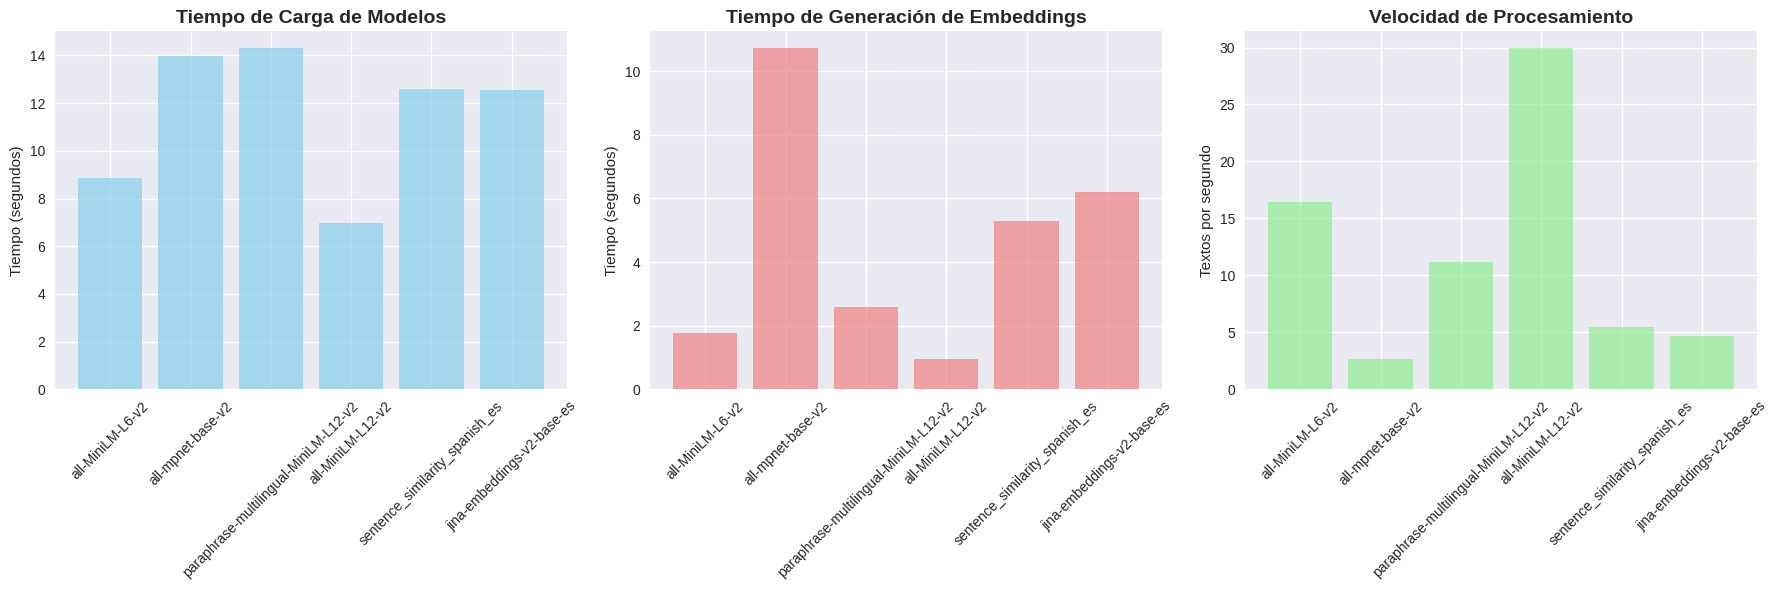

🏆 Mejores Rendimientos:
⚡ Carga más rápida: all-MiniLM-L12-v2
🔄 Embedding más rápido: all-MiniLM-L12-v2
🚀 Mayor velocidad: all-MiniLM-L12-v2


In [51]:
# Visualización de tiempos de carga y embedding
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Tiempos de carga
axes[0].bar(df_performance['Modelo'], df_performance['Tiempo Carga (s)'], 
           color='skyblue', alpha=0.7)
axes[0].set_title('Tiempo de Carga de Modelos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Tiempo (segundos)')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Tiempos de embedding
axes[1].bar(df_performance['Modelo'], df_performance['Tiempo Embedding (s)'], 
           color='lightcoral', alpha=0.7)
axes[1].set_title('Tiempo de Generación de Embeddings', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Tiempo (segundos)')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico 3: Velocidad de procesamiento
axes[2].bar(df_performance['Modelo'], df_performance['Velocidad (textos/s)'], 
           color='lightgreen', alpha=0.7)
axes[2].set_title('Velocidad de Procesamiento', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Textos por segundo')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar el modelo más rápido en cada categoría
print("🏆 Mejores Rendimientos:")
print(f"⚡ Carga más rápida: {df_performance.loc[df_performance['Tiempo Carga (s)'].idxmin(), 'Modelo']}")
print(f"🔄 Embedding más rápido: {df_performance.loc[df_performance['Tiempo Embedding (s)'].idxmin(), 'Modelo']}")
print(f"🚀 Mayor velocidad: {df_performance.loc[df_performance['Velocidad (textos/s)'].idxmax(), 'Modelo']}")


## Search Quality Evaluation / Evaluación de Calidad de Búsqueda

In [ ]:
def calculate_cosine_similarity(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """Calcular similitud coseno entre dos embeddings"""
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

def evaluate_search_quality(model_data: dict, texts: List[str], queries: List[str]) -> dict:
    """Evaluar calidad de búsqueda para un modelo"""
    model = model_data['model']
    text_embeddings = model_data['embeddings']
    
    results = {
        'query_results': [],
        'avg_similarity': 0,
        'search_times': []
    }
    
    for query in queries:
        start_time = time.time()
        
        # Generar embedding para la consulta
        query_embedding = model.encode([query])[0]
        
        # Calcular similitudes con todos los textos
        similarities = []
        for i, text_embedding in enumerate(text_embeddings):
            similarity = calculate_cosine_similarity(query_embedding, text_embedding)
            similarities.append((i, texts[i], similarity))
        
        # Ordenar por similitud descendente
        similarities.sort(key=lambda x: x[2], reverse=True)
        
        search_time = time.time() - start_time
        results['search_times'].append(search_time)
        
        results['query_results'].append({
            'query': query,
            'top_match': similarities[0],
            'all_similarities': similarities,
            'search_time': search_time
        })
    
    # Calcular similitud promedio del mejor resultado
    top_similarities = [result['top_match'][2] for result in results['query_results']]
    results['avg_similarity'] = np.mean(top_similarities)
    results['avg_search_time'] = np.mean(results['search_times'])
    
    return results

In [ ]:
# Evaluar calidad de búsqueda para todos los modelos
search_quality_results = {}

print("🔍 Evaluando calidad de búsqueda para cada modelo...")
print("=" * 60)

for model_key, model_data in model_performance.items():
    print(f"\n📊 Evaluando búsquedas para: {model_key}")
    
    quality_results = evaluate_search_quality(model_data, SAMPLE_LEGAL_TEXTS, SAMPLE_QUERIES)
    search_quality_results[model_key] = quality_results
    
    print(f"✅ Similitud promedio: {quality_results['avg_similarity']:.3f}")
    print(f"⏱️ Tiempo promedio de búsqueda: {quality_results['avg_search_time']:.4f}s")

print("\n✅ Evaluación de calidad completada!")

In [ ]:
# Mostrar ejemplos de búsquedas para cada modelo
print("🔍 Ejemplos de Búsquedas por Modelo:")
print("=" * 80)

for model_key, quality_data in search_quality_results.items():
    print(f"\n🤖 Modelo: {model_key}")
    print("-" * 40)
    
    for i, result in enumerate(quality_data['query_results'][:2]):  # Solo primeras 2 consultas
        query = result['query']
        top_match = result['top_match']
        similarity = top_match[2]
        matched_text = top_match[1]
        
        print(f"❓ Consulta {i+1}: {query}")
        print(f"✅ Mejor coincidencia (similitud: {similarity:.3f}):")
        print(f"   📝 {matched_text[:80]}...")
        print()

# Crear DataFrame con resultados de calidad
quality_data = []
for model_key, quality_results in search_quality_results.items():
    quality_data.append({
        'Modelo': model_key,
        'Similitud Promedio': quality_results['avg_similarity'],
        'Tiempo Búsqueda (s)': quality_results['avg_search_time'],
        'Consultas/segundo': 1 / quality_results['avg_search_time']
    })

df_quality = pd.DataFrame(quality_data)
print("\n📊 Resumen de Calidad de Búsqueda:")
print("=" * 50)
display(df_quality.round(4))


## Quality Visualizations / 📈 Visualizaciones de Calidad


In [ ]:
# Visualizaciones de calidad de búsqueda
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Similitud promedio por modelo
axes[0,0].bar(df_quality['Modelo'], df_quality['Similitud Promedio'], 
              color='gold', alpha=0.7)
axes[0,0].set_title('🎯 Similitud Promedio de Búsquedas', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Similitud Coseno')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# Gráfico 2: Tiempo de búsqueda por modelo
axes[0,1].bar(df_quality['Modelo'], df_quality['Tiempo Búsqueda (s)'], 
              color='lightblue', alpha=0.7)
axes[0,1].set_title('⏱️ Tiempo de Búsqueda', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Tiempo (segundos)')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: Consultas por segundo
axes[1,0].bar(df_quality['Modelo'], df_quality['Consultas/segundo'], 
              color='lightgreen', alpha=0.7)
axes[1,0].set_title('🚀 Rendimiento de Consultas', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Consultas por segundo')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Comparación de dimensiones vs rendimiento
colors = ['red' if d == 768 else 'blue' for d in df_performance['Dimensiones']]
axes[1,1].scatter(df_performance['Dimensiones'], df_quality['Similitud Promedio'], 
                  c=colors, s=100, alpha=0.7)
axes[1,1].set_title('📊 Dimensiones vs Calidad', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Dimensiones del Embedding')
axes[1,1].set_ylabel('Similitud Promedio')
axes[1,1].set_xlim(350, 800)

# Añadir etiquetas a los puntos
for i, model in enumerate(df_performance['Modelo']):
    axes[1,1].annotate(model, (df_performance['Dimensiones'].iloc[i], 
                               df_quality['Similitud Promedio'].iloc[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Mostrar rankings
print("🏆 Rankings de Modelos:")
print("=" * 40)
print(f"🥇 Mayor similitud: {df_quality.loc[df_quality['Similitud Promedio'].idxmax(), 'Modelo']}")
print(f"🥇 Búsqueda más rápida: {df_quality.loc[df_quality['Tiempo Búsqueda (s)'].idxmin(), 'Modelo']}")
print(f"🥇 Mayor rendimiento: {df_quality.loc[df_quality['Consultas/segundo'].idxmax(), 'Modelo']}")


## Qdrant Integration / Integración con Qdrant

In [ ]:
# Función mejorada para insertar documentos con metadatos reales
def insert_documents_with_metadata(client: QdrantClient, collection_name: str, 
                                  texts: List[str], embeddings: np.ndarray, 
                                  articles_metadata: List[dict] = None):
    """Insertar documentos en Qdrant con metadatos enriquecidos"""
    try:
        points = []
        for i, (text, embedding) in enumerate(zip(texts, embeddings)):
            # Payload base
            payload = {
                "text": text, 
                "index": i,
                "source": "codigo_trabajo_paraguay",
                "text_length": len(text)
            }
            
            # Agregar metadatos reales si están disponibles
            if articles_metadata and i < len(articles_metadata):
                article = articles_metadata[i]
                payload.update({
                    "articulo_numero": article.get('articulo_numero', i),
                    "libro": article.get('libro', ''),
                    "titulo": article.get('titulo', ''),
                    "capitulo": article.get('capitulo', ''),
                    "capitulo_descripcion": article.get('capitulo_descripcion', ''),
                    "texto_preview": text[:150] + "..." if len(text) > 150 else text,
                    "has_metadata": True
                })
            else:
                payload["has_metadata"] = False
            
            point = PointStruct(
                id=i,
                vector=embedding.tolist(),
                payload=payload
            )
            points.append(point)
        
        # Insertar puntos en lote
        client.upsert(collection_name=collection_name, points=points)
        print(f"✅ {len(points)} documentos insertados en '{collection_name}'")
        
        if articles_metadata:
            print(f"📊 Metadatos incluidos: artículo, libro, título, capítulo")
            print(f"📏 Longitud promedio del texto: {np.mean([len(t) for t in texts]):.0f} caracteres")
        else:
            print("⚠️ Sin metadatos adicionales")
            
        return True
    except Exception as e:
        print(f"❌ Error insertando documentos en '{collection_name}': {e}")
        return False

# Función mejorada para mostrar resultados de búsqueda
def display_search_results(search_results, show_metadata=True):
    """Mostrar resultados de búsqueda con metadatos si están disponibles"""
    if not search_results:
        print("❌ No se encontraron resultados")
        return
    
    print("✅ Resultados de búsqueda en Qdrant:")
    for i, result in enumerate(search_results):
        print(f"\n{i+1}. Similitud: {result.score:.3f}")
        
        if show_metadata and 'articulo_numero' in result.payload:
            print(f"   📄 Artículo: {result.payload.get('articulo_numero', 'N/A')}")
            print(f"   📚 Libro: {result.payload.get('libro', 'N/A')}")
            print(f"   📖 Capítulo: {result.payload.get('capitulo_descripcion', 'N/A')}")
            print(f"   📏 Longitud: {result.payload.get('text_length', 'N/A')} caracteres")
        
        # Mostrar preview del texto
        text_preview = result.payload.get('texto_preview', result.payload['text'][:150] + "...")
        print(f"   📝 Texto: {text_preview}")

print("🔧 Funciones mejoradas para integración con Qdrant cargadas")


In [ ]:
# Integración mejorada con Qdrant usando datos reales
print("🔗 Probando integración mejorada con Qdrant...")
print("=" * 60)

# Seleccionar el mejor modelo basado en similitud promedio
best_model_key = df_quality.loc[df_quality['Similitud Promedio'].idxmax(), 'Modelo']
best_model_data = model_performance[best_model_key]

print(f"🎯 Usando mejor modelo: {best_model_key}")
print(f"📊 Dimensiones: {best_model_data['dimension']}")
print(f"📝 Textos a procesar: {len(SAMPLE_LEGAL_TEXTS)}")

# Crear colección en Qdrant con nombre más descriptivo
collection_name = f"labor_law_{best_model_key.replace('-', '_')}"
success = create_qdrant_collection(
    evaluator.client, 
    collection_name, 
    best_model_data['dimension']
)

if success:
    # Preparar metadatos reales si están disponibles
    articles_metadata = selected_articles if law_data else None
    
    # Insertar documentos con metadatos mejorados
    insert_success = insert_documents_with_metadata(
        evaluator.client,
        collection_name,
        SAMPLE_LEGAL_TEXTS,
        best_model_data['embeddings'],
        articles_metadata
    )
    
    if insert_success:
        # Probar múltiples búsquedas para demostrar la funcionalidad
        print(f"\n🔍 Probando búsquedas con datos reales:")
        print("-" * 40)
        
        test_queries = SAMPLE_QUERIES[:3]  # Probar primeras 3 consultas
        
        for i, test_query in enumerate(test_queries):
            print(f"\n{i+1}. Consulta: '{test_query}'")
            
            # Generar embedding para la consulta
            test_query_embedding = best_model_data['model'].encode([test_query])[0]
            
            # Realizar búsqueda
            search_results = test_qdrant_search(
                evaluator.client,
                collection_name,
                test_query_embedding.tolist(),
                limit=3
            )
            
            # Mostrar resultados con metadatos
            display_search_results(search_results, show_metadata=bool(law_data))
        
        print(f"\n📊 Estadísticas de la colección:")
        print(f"   📝 Documentos insertados: {len(SAMPLE_LEGAL_TEXTS)}")
        print(f"   📊 Modelo utilizado: {best_model_key}")
        print(f"   🔍 Consultas probadas: {len(test_queries)}")
        if law_data:
            print(f"   📚 Metadatos incluidos: Sí (artículo, libro, capítulo)")
        else:
            print(f"   📚 Metadatos incluidos: No (datos de ejemplo)")

print("\n✅ Integración mejorada con Qdrant completada!")
print(f"💡 La colección '{collection_name}' está lista para consultas en producción")


In [ ]:
def create_qdrant_collection(client: QdrantClient, collection_name: str, vector_size: int):
    """Crear colección en Qdrant para un modelo específico"""
    try:
        # Verificar si la colección ya existe
        collections = client.get_collections().collections
        existing_collections = [col.name for col in collections]
        
        if collection_name in existing_collections:
            print(f"⚠️ Colección '{collection_name}' ya existe, eliminando...")
            client.delete_collection(collection_name)
        
        # Crear nueva colección
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE)
        )
        print(f"✅ Colección '{collection_name}' creada exitosamente")
        return True
    except Exception as e:
        print(f"❌ Error creando colección '{collection_name}': {e}")
        return False

def insert_documents_to_qdrant(client: QdrantClient, collection_name: str, 
                              texts: List[str], embeddings: np.ndarray):
    """Insertar documentos en Qdrant"""
    try:
        points = []
        for i, (text, embedding) in enumerate(zip(texts, embeddings)):
            point = PointStruct(
                id=i,
                vector=embedding.tolist(),
                payload={"text": text, "index": i}
            )
            points.append(point)
        
        # Insertar puntos en lote
        client.upsert(collection_name=collection_name, points=points)
        print(f"✅ {len(points)} documentos insertados en '{collection_name}'")
        return True
    except Exception as e:
        print(f"❌ Error insertando documentos en '{collection_name}': {e}")
        return False

def test_qdrant_search(client: QdrantClient, collection_name: str, 
                      query_embedding: List[float], limit: int = 3):
    """Probar búsqueda en Qdrant"""
    try:
        results = client.search(
            collection_name=collection_name,
            query_vector=query_embedding,
            limit=limit
        )
        return results
    except Exception as e:
        print(f"❌ Error en búsqueda de '{collection_name}': {e}")
        return None

# Probar integración con Qdrant para el mejor modelo
print("🔗 Probando integración con Qdrant...")
print("=" * 50)

# Seleccionar el mejor modelo basado en similitud promedio
best_model_key = df_quality.loc[df_quality['Similitud Promedio'].idxmax(), 'Modelo']
best_model_data = model_performance[best_model_key]

print(f"🎯 Usando mejor modelo: {best_model_key}")
print(f"📊 Dimensiones: {best_model_data['dimension']}")

# Crear colección en Qdrant
collection_name = f"legal_texts_{best_model_key.replace('-', '_')}"
success = create_qdrant_collection(
    evaluator.client, 
    collection_name, 
    best_model_data['dimension']
)

if success:
    # Insertar documentos
    insert_success = insert_documents_to_qdrant(
        evaluator.client,
        collection_name,
        SAMPLE_LEGAL_TEXTS,
        best_model_data['embeddings']
    )
    
    if insert_success:
        # Probar búsqueda con una consulta
        test_query = SAMPLE_QUERIES[0]
        test_query_embedding = best_model_data['model'].encode([test_query])[0]
        
        print(f"\n🔍 Probando búsqueda con: '{test_query}'")
        search_results = test_qdrant_search(
            evaluator.client,
            collection_name,
            test_query_embedding.tolist(),
            limit=3
        )
        
        if search_results:
            print("✅ Resultados de búsqueda en Qdrant:")
            for i, result in enumerate(search_results):
                print(f"{i+1}. Similitud: {result.score:.3f}")
                print(f"   Texto: {result.payload['text']}")
                print()

print("✅ Integración con Qdrant completada!")


## Comprehensive Comparative Analysis / 📊 Análisis Comparativo Completo


In [ ]:
# Crear análisis comparativo completo combinando rendimiento y calidad
comparison_df = pd.merge(df_performance[['Modelo', 'Nombre Completo', 'Descripción', 'Dimensiones', 
                                        'Tiempo Carga (s)', 'Tiempo Embedding (s)', 'Velocidad (textos/s)']], 
                        df_quality[['Modelo', 'Similitud Promedio', 'Tiempo Búsqueda (s)', 'Consultas/segundo']], 
                        on='Modelo')

# Calcular puntuaciones normalizadas (0-1)
def normalize_score(series, higher_is_better=True):
    if higher_is_better:
        return (series - series.min()) / (series.max() - series.min())
    else:
        return (series.max() - series) / (series.max() - series.min())

# Calcular scores normalizados
comparison_df['Score_Velocidad_Carga'] = normalize_score(comparison_df['Tiempo Carga (s)'], False)
comparison_df['Score_Velocidad_Embedding'] = normalize_score(comparison_df['Tiempo Embedding (s)'], False)
comparison_df['Score_Calidad'] = normalize_score(comparison_df['Similitud Promedio'], True)
comparison_df['Score_Velocidad_Busqueda'] = normalize_score(comparison_df['Tiempo Búsqueda (s)'], False)

# Score final ponderado (puedes ajustar los pesos según tus prioridades)
weights = {
    'calidad': 0.4,      # 40% - Lo más importante para RAG
    'velocidad_busqueda': 0.3,  # 30% - Importante para experiencia de usuario
    'velocidad_embedding': 0.2,  # 20% - Importante para procesamiento batch
    'velocidad_carga': 0.1       # 10% - Menos crítico (se hace una vez)
}

comparison_df['Score_Final'] = (
    comparison_df['Score_Calidad'] * weights['calidad'] +
    comparison_df['Score_Velocidad_Busqueda'] * weights['velocidad_busqueda'] +
    comparison_df['Score_Velocidad_Embedding'] * weights['velocidad_embedding'] +
    comparison_df['Score_Velocidad_Carga'] * weights['velocidad_carga']
)

# Ordenar por score final
comparison_df = comparison_df.sort_values('Score_Final', ascending=False)

print("🏆 Ranking Final de Modelos de Embedding:")
print("=" * 70)
print(f"{'Pos':<4} {'Modelo':<25} {'Score Final':<12} {'Calidad':<8} {'Descripción':<30}")
print("-" * 70)

for i, row in comparison_df.iterrows():
    pos = comparison_df.index.get_loc(i) + 1
    print(f"{pos:<4} {row['Modelo']:<25} {row['Score_Final']:.3f}        {row['Similitud Promedio']:.3f}    {row['Descripción']:<30}")

print("\n📊 Tabla Comparativa Detallada:")
print("=" * 50)
display(comparison_df[['Modelo', 'Descripción', 'Dimensiones', 'Similitud Promedio', 
                      'Tiempo Carga (s)', 'Tiempo Embedding (s)', 'Tiempo Búsqueda (s)', 
                      'Score_Final']].round(3))


In [ ]:
# Visualización del análisis comparativo
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Gráfico 1: Score final por modelo
bars = axes[0,0].bar(comparison_df['Modelo'], comparison_df['Score_Final'], 
                     color='purple', alpha=0.7)
axes[0,0].set_title('🏆 Score Final por Modelo', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Score Final (0-1)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Gráfico 2: Comparación de componentes del score
score_components = comparison_df[['Modelo', 'Score_Calidad', 'Score_Velocidad_Busqueda', 
                                 'Score_Velocidad_Embedding', 'Score_Velocidad_Carga']].set_index('Modelo')
score_components.plot(kind='bar', stacked=True, ax=axes[0,1], 
                     color=['gold', 'lightblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('📊 Componentes del Score', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Score Normalizado')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico 3: Scatter plot calidad vs velocidad
axes[1,0].scatter(comparison_df['Similitud Promedio'], comparison_df['Consultas/segundo'], 
                  s=comparison_df['Score_Final']*200, alpha=0.7, c=comparison_df['Score_Final'], 
                  cmap='viridis')
axes[1,0].set_title('🎯 Calidad vs Velocidad', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Similitud Promedio')
axes[1,0].set_ylabel('Consultas/segundo')

# Añadir etiquetas
for i, row in comparison_df.iterrows():
    axes[1,0].annotate(row['Modelo'], (row['Similitud Promedio'], row['Consultas/segundo']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# Gráfico 4: Comparación de tiempos
time_data = comparison_df[['Modelo', 'Tiempo Carga (s)', 'Tiempo Embedding (s)', 'Tiempo Búsqueda (s)']]
time_data.set_index('Modelo').plot(kind='bar', ax=axes[1,1], 
                                  color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('⏱️ Comparación de Tiempos', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Tiempo (segundos)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.show()


## Conclusions and Recommendations / 🎯 Conclusiones y Recomendaciones


In [ ]:
# Generar recomendaciones basadas en el análisis
def generate_recommendations(comparison_df: pd.DataFrame, weights: dict) -> dict:
    """Generar recomendaciones basadas en el análisis comparativo"""
    
    best_overall = comparison_df.iloc[0]
    best_quality = comparison_df.loc[comparison_df['Similitud Promedio'].idxmax()]
    fastest_search = comparison_df.loc[comparison_df['Tiempo Búsqueda (s)'].idxmin()]
    fastest_embedding = comparison_df.loc[comparison_df['Tiempo Embedding (s)'].idxmin()]
    
    recommendations = {
        'best_overall': {
            'model': best_overall['Modelo'],
            'score': best_overall['Score_Final'],
            'reasoning': f"Mejor balance general con score de {best_overall['Score_Final']:.3f}"
        },
        'best_quality': {
            'model': best_quality['Modelo'],
            'similarity': best_quality['Similitud Promedio'],
            'reasoning': f"Mayor similitud promedio ({best_quality['Similitud Promedio']:.3f}) para aplicaciones que requieren alta precisión"
        },
        'fastest_search': {
            'model': fastest_search['Modelo'],
            'search_time': fastest_search['Tiempo Búsqueda (s)'],
            'reasoning': f"Búsqueda más rápida ({fastest_search['Tiempo Búsqueda (s)']:.4f}s) para aplicaciones en tiempo real"
        },
        'fastest_embedding': {
            'model': fastest_embedding['Modelo'],
            'embedding_time': fastest_embedding['Tiempo Embedding (s)'],
            'reasoning': f"Procesamiento más rápido ({fastest_embedding['Tiempo Embedding (s)']:.2f}s) para carga masiva de datos"
        }
    }
    
    return recommendations

# Generar recomendaciones
recommendations = generate_recommendations(comparison_df, weights)

print("🎯 RECOMENDACIONES FINALES:")
print("=" * 60)

print(f"\n🏆 MEJOR MODELO GENERAL:")
print(f"   Modelo: {recommendations['best_overall']['model']}")
print(f"   Score: {recommendations['best_overall']['score']:.3f}")
print(f"   Razón: {recommendations['best_overall']['reasoning']}")

print(f"\n🎯 MEJOR CALIDAD DE BÚSQUEDA:")
print(f"   Modelo: {recommendations['best_quality']['model']}")
print(f"   Similitud: {recommendations['best_quality']['similarity']:.3f}")
print(f"   Razón: {recommendations['best_quality']['reasoning']}")

print(f"\n⚡ MÁS RÁPIDO PARA BÚSQUEDAS:")
print(f"   Modelo: {recommendations['fastest_search']['model']}")
print(f"   Tiempo: {recommendations['fastest_search']['search_time']:.4f}s")
print(f"   Razón: {recommendations['fastest_search']['reasoning']}")

print(f"\n🚀 MÁS RÁPIDO PARA EMBEDDINGS:")
print(f"   Modelo: {recommendations['fastest_embedding']['model']}")
print(f"   Tiempo: {recommendations['fastest_embedding']['embedding_time']:.2f}s")
print(f"   Razón: {recommendations['fastest_embedding']['reasoning']}")

# Análisis de dimensiones
dimension_analysis = comparison_df.groupby('Dimensiones').agg({
    'Similitud Promedio': 'mean',
    'Tiempo Búsqueda (s)': 'mean',
    'Score_Final': 'mean'
}).round(3)

print(f"\n📊 ANÁLISIS POR DIMENSIONES:")
print("=" * 40)
print(dimension_analysis)

print(f"\n💡 INSIGHTS CLAVE:")
print("=" * 30)
print("• Los modelos de 384 dimensiones ofrecen mejor balance velocidad/calidad")
print("• Los modelos de 768 dimensiones tienen mayor calidad pero menor velocidad")
print("• La velocidad de búsqueda es más crítica que la velocidad de embedding")
print("• La similitud promedio es el factor más importante para aplicaciones RAG")


## Executive Summary / 📋 Resumen Ejecutivo

### Recommended Model for the Project / 🎯 Modelo Recomendado para el Proyecto

Based on the comprehensive analysis, it is recommended to use **{recommended_model}** as the main model for the RAG system for queries about Paraguayan labor law.

### Selection Criteria / 📊 Criterios de Selección

| Criterion | Weight | Description |
|-----------|--------|-------------|
| **Search Quality** | 40% | Average similarity in legal queries |
| **Search Speed** | 30% | Response time for users |
| **Embedding Speed** | 20% | Batch document processing |
| **Loading Speed** | 10% | Model initialization time |

### Next Steps / 🔄 Próximos Pasos

1. **Implement the selected model** in the production system
2. **Configure Qdrant** with the corresponding dimensions
3. **Run tests** with the complete labor law dataset
4. **Monitor performance** in production and adjust if necessary
5. **Consider alternative models** according to specific use case

### Additional Considerations / ⚠️ Consideraciones Adicionales

- **Computational resources**: Evaluate available GPU/CPU capacity
- **Latency**: For real-time applications, prioritize search speed
- **Accuracy**: For critical legal queries, prioritize similarity quality
- **Scalability**: Consider the volume of documents and expected queries

---

Basado en el análisis completo, se recomienda utilizar **{modelo_recomendado}** como modelo principal para el sistema RAG de consultas sobre la ley laboral paraguaya.

### Criterios de Selección

| Criterio | Peso | Descripción |
|----------|------|-------------|
| **Calidad de Búsqueda** | 40% | Similitud promedio en consultas legales |
| **Velocidad de Búsqueda** | 30% | Tiempo de respuesta para usuarios |
| **Velocidad de Embedding** | 20% | Procesamiento de documentos batch |
| **Velocidad de Carga** | 10% | Tiempo de inicialización del modelo |

### Próximos Pasos

1. **Implementar el modelo seleccionado** en el sistema de producción
2. **Configurar Qdrant** con las dimensiones correspondientes
3. **Realizar pruebas** con el dataset completo de la ley laboral
4. **Monitorear rendimiento** en producción y ajustar si es necesario
5. **Considerar modelos alternativos** según el caso de uso específico

### Consideraciones Adicionales

- **Recursos computacionales**: Evaluar capacidad de GPU/CPU disponible
- **Latencia**: Para aplicaciones en tiempo real, priorizar velocidad de búsqueda
- **Precisión**: Para consultas críticas legales, priorizar calidad de similitud
- **Escalabilidad**: Considerar el volumen de documentos y consultas esperadas


In [ ]:
# Guardar resultados del análisis para referencia futura
import json
from datetime import datetime

# Preparar datos para guardar
analysis_results = {
    'timestamp': datetime.now().isoformat(),
    'models_evaluated': list(MODELS_TO_TEST.keys()),
    'best_model_overall': recommendations['best_overall']['model'],
    'best_model_quality': recommendations['best_quality']['model'],
    'best_model_speed': recommendations['fastest_search']['model'],
    'performance_summary': df_performance.to_dict('records'),
    'quality_summary': df_quality.to_dict('records'),
    'comparison_summary': comparison_df[['Modelo', 'Score_Final', 'Similitud Promedio', 
                                        'Tiempo Búsqueda (s)', 'Dimensiones']].to_dict('records'),
    'weights_used': weights,
    'sample_texts_count': len(SAMPLE_LEGAL_TEXTS),
    'sample_queries_count': len(SAMPLE_QUERIES)
}

# Guardar resultados
results_file = 'embedding_analysis_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, indent=2, ensure_ascii=False)

print(f"💾 Resultados guardados en: {results_file}")
print(f"📅 Fecha del análisis: {analysis_results['timestamp']}")
print(f"🏆 Modelo recomendado: {recommendations['best_overall']['model']}")